In [481]:
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
import h5py
import cartopy
import pyart
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
# pyplot needed to plot the dataset, but animation only needed much further down.
from matplotlib import animation
%matplotlib inline

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display

import sys
sys.path.append('~/PlotGallery')
from matplotlibconfig import basic
basic()
import proplot as pplt

In [505]:
basic()

In [32]:
dict_hurricanes= {
    'Barry': {'datetime': [], 'points':[]},
    'Beta': {'datetime': [], 'points':[]},
    'Cindy': {'datetime': [], 'points':[]},
    'Delta': {'datetime': [], 'points':[]},
    'Hanna': {'datetime': [], 'points':[]},
    'Harvey': {'datetime': [], 'points':[]},
    'Imelda': {'datetime': [], 'points':[]},
    'Laura': {'datetime': [], 'points':[]},
    'Florence': {'datetime': [], 'points': []}
}

In [33]:
for event in dict_hurricanes.keys():
    fname= glob('tracks/%s/*_pts.shp'%(event))[0]
    pnts= gpd.read_file(fname)
    pnts.DTG= pd.to_datetime(pnts.DTG, format='%Y%m%d%H')
    dict_hurricanes[event]['datetime']= sorted(pnts.DTG.tolist())
    order= np.argsort(pnts.DTG.values)
    dict_hurricanes[event]['points']= list(zip(pnts.LON.values[order], pnts.LAT.values[order]))

In [4]:
from netCDF4 import Dataset

In [319]:
ds_obj= Dataset('/home/ZhiLi/soilmoisture/data/rain/MTD_Florence/StageIV/mtd_MTD_out_20180907_180000V_obj.nc', 'r')

In [622]:
lons= ds_obj['lon'][:]
lats= ds_obj['lat'][:]
obj = ds_obj['fcst_object_id'][:]
rain= ds_obj['fcst_raw'][:]

In [332]:
obj[obj==0]= np.ma.masked
rain[rain<=0]= np.ma.masked

In [328]:
times= pd.date_range('2018-09-07 18:00:00', '2018-09-17 18:00:00', freq='H')

In [334]:
from matplotlib.colors import from_levels_and_colors

In [335]:
gist= plt.get_cmap('gist_ncar')

In [618]:
info_3d= pd.read_csv('data/rain/MTD_Florence/StageIV/mtd_MTD_out_20180907_180000V_3d_single_simple.txt', sep='\s+')
info_2d= pd.read_csv('data/rain/MTD_Florence/StageIV/mtd_MTD_out_20180907_180000V_2d.txt', sep='\s+')
info_2d.FCST_VALID= pd.to_datetime(info_2d.FCST_VALID, format='%Y%m%d_%H%M%S')

In [348]:
for t in range(len(obj)):
    if t%10==0:
        print('%d/%d'%(t,len(obj)))
    _obj= obj[t,:,:]
    time= times[t]
    fig, axes= plt.subplots(1,2,facecolor='white',subplot_kw={'projection': cartopy.crs.PlateCarree()})
    ax= axes[0]
    cmap, norm = from_levels_and_colors(np.arange(1,105,1), [gist(num/103) for num in np.arange(1,104,1)])
    ax.pcolormesh(lons, lats, _obj, cmap=cmap, norm=norm)
    ax.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='w', zorder=0)
    for uniq in np.unique(_obj):
        if uniq!=0:
            centroid_x= lons[_obj==uniq].mean()
            centroid_y= lats[_obj==uniq].mean()
            ax.text(centroid_x, centroid_y, '%d'%uniq)
    ax.set_title(time.strftime('%Y-%m-%dT%H:%M:%S'))
    section= pd.to_datetime(dict_hurricanes['Florence']['datetime']).get_loc(time, method='nearest')
    locs= np.stack(dict_hurricanes['Florence']['points'])[:section+1,:]
    ax.plot(locs[:,0], locs[:,1], 'r-', linewidth=2, marker='o', transform=cartopy.crs.PlateCarree())
    ax.coastlines()
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
    
    ax= axes[1]
    _rain= rain[t,:,:]
    cmap, norm = from_levels_and_colors(np.arange(1,115,10), [cmap_precip(num/95) for num in np.arange(1,105,10)])
    map=ax.pcolormesh(lons, lats, _rain, cmap=cmap, norm=norm)
    ax.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='w', zorder=0)
    for uniq in np.unique(_obj):
        if uniq!=0:
            centroid_x= lons[_obj==uniq].mean()
            centroid_y= lats[_obj==uniq].mean()
            ax.text(centroid_x, centroid_y, '%d'%uniq)
    ax.set_title(time.strftime('%Y-%m-%dT%H:%M:%S'))
    section= pd.to_datetime(dict_hurricanes['Florence']['datetime']).get_loc(time, method='nearest')
    locs= np.stack(dict_hurricanes['Florence']['points'])[:section+1,:]
    ax.plot(locs[:,0], locs[:,1], 'r-', linewidth=2, marker='o', transform=cartopy.crs.PlateCarree())
    ax.coastlines()
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
    cb=fig.colorbar(mappable=map,fraction=0.02, ax=axes, pad=0.01)
    cb.set_label('Rainfall rate (mm/hr)')    
    fig.savefig('src/img%04d.png'%t)
    plt.close();
plt.show();

0/241
10/241
20/241
30/241
40/241
50/241
60/241
70/241
80/241
90/241
100/241
110/241
120/241
130/241
140/241
150/241
160/241
170/241
180/241
190/241
200/241
210/241
220/241
230/241
240/241


In [69]:
cmap_precip= pyart.graph.cm.NWSRef

In [71]:
cmap, norm = from_levels_and_colors(np.arange(1,115,10), [cmap_precip(num/95) for num in np.arange(1,105,10)])

In [104]:
cmap, norm = from_levels_and_colors(np.arange(1,105,1), [gist(num/103) for num in np.arange(1,104,1)])

In [120]:
import matplotlib

In [354]:
norm=matplotlib.colors.LogNorm(vmin=info_3d.VOLUME.min(), vmax=np.exp(10), clip=True)
cmap= cmap_precip

In [429]:
for t, ref in enumerate(pd.date_range('20180907180000', '20180917180000', freq='H')):
    if t%10==0:
        print('%d/%d'%(t,len(obj)))    
    fig= plt.figure(facecolor='white')
    ax= fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
    obj_id= np.unique(info_2d.OBJECT_ID)
    for _id in obj_id:
        _df = info_2d[(info_2d.OBJECT_ID==_id)]
        if ref in _df.FCST_VALID.tolist():
            _df = _df.set_index('FCST_VALID').loc[:ref]
            ax.plot(_df.CENTROID_LON,_df.CENTROID_LAT, color=cmap(norm(info_3d.loc[int(_id[-3:])-1, 'VOLUME'])),
                            marker='o')
            ax.text(_df['CENTROID_LON'].mean(), _df['CENTROID_LAT'].mean(),
                   int(_id[-3:]))        
        else:
            pass
    #         ax.contour()
    ax.add_feature(cartopy.feature.STATES, alpha=0.6, facecolor='w', zorder=0)

    prod= xr.Variable('prod', [1,2])
    _sm= xr.concat([ds_sm.sm_smap.sel(time_smap=(ref-pd.Timedelta(days=2)).strftime('%Y-%m-%d')).mean(dim='time_smap'),
                   ds_sm.sm_cygnss.sel(time_cygnss=(ref-pd.Timedelta(days=2)).strftime('%Y-%m-%d')).mean(dim='time_cygnss')],
                   dim=prod).mean(dim='prod')
    map=ax.pcolormesh(ds_sm.lon, ds_sm.lat,
                _sm,
               vmin=0, vmax=0.7, cmap='viridis_r', alpha=0.6)
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb=plt.colorbar(sm,pad=0.01)
    cb.set_label('Rainfall volume (m^3)')
    inset=fig.add_axes([0.6,0.2,0.2,0.01])
    # inset.axis('off')
    cb2=fig.colorbar(cax=inset, mappable=map, orientation='horizontal',
                    ticks=np.arange(0,0.7,0.1))
    cb2.set_label('Antecedent soil moisture (cm^3/cm^3)')
    ax.set_title(ref.strftime("%Y-%m-%dT%H:%M:%S"))
    fig.savefig('src/img%04d.png'%t)
    plt.close();
plt.show();

0/241
10/241
20/241
30/241
40/241
50/241
60/241
70/241
80/241
90/241
100/241
110/241
120/241
130/241
140/241
150/241
160/241
170/241
180/241
190/241
200/241
210/241
220/241
230/241
240/241


# Association with soil moisture 

In [200]:
ds_sm= xr.open_dataset('data/data_Florence.nc').load()

In [208]:
sm_23 = []
obj_id=72
first=True
for dt in ds_sm.time_cygnss.values:
    dt= pd.to_datetime(dt)
    if dt<=pd.to_datetime('20180910000000'):
        if first:
            itimes, irows, icols= np.where(obj==obj_id)
            tar_lons= lons[obj[itimes[0]]==obj_id]; tar_lats= lats[obj[itimes[0]]==obj_id]
            _sm= ds_sm.sm_cygnss.sel(lon=tar_lons, method='nearest').sel(lat=tar_lats,method='nearest')
            sm_23.append(_sm.sel(time_cygnss=dt).mean().values)
            first=False
        else:
            sm_23.append(_sm.sel(time_cygnss=dt).mean().values)
    else:
        ind= (dt - pd.to_datetime('20180910000000')).seconds//3600
        tar_lons= lons[obj[itimes[ind]]==obj_id]; tar_lats= lats[obj[itimes[ind]]==obj_id]
        _sm= ds_sm.sm_cygnss.sel(lon=tar_lons, method='nearest').sel(lat=tar_lats,method='nearest')
        sm_23.append(_sm.sel(time_cygnss=dt).mean().values)

In [209]:
rr= []
for dt in range(len(rain)):
    if dt>=itimes[0] and dt<itimes[-1]:
        _rr= rain[dt][obj[dt]==obj_id]
        rr.append(np.nanmean(_rr))
    else:
        rr.append(np.nan)

In [430]:
info_2d.FCST_VALID

0     2018-09-07 18:00:00
1     2018-09-07 19:00:00
2     2018-09-07 20:00:00
3     2018-09-07 18:00:00
4     2018-09-07 19:00:00
              ...        
485   2018-09-17 14:00:00
486   2018-09-17 15:00:00
487   2018-09-17 16:00:00
488   2018-09-17 17:00:00
489   2018-09-17 18:00:00
Name: FCST_VALID, Length: 490, dtype: datetime64[ns]

In [431]:
info_2d

,VERSION,MODEL,DESC,FCST_LEAD,FCST_VALID,OBS_LEAD,OBS_VALID,T_DELTA,FCST_T_BEG,FCST_T_END,FCST_RAD,FCST_THR,OBS_T_BEG,OBS_T_END,OBS_RAD,...,OBJECT_ID,OBJECT_CAT,TIME_INDEX,AREA,CENTROID_X,CENTROID_Y,CENTROID_LAT,CENTROID_LON,AXIS_ANG,INTENSITY_10,INTENSITY_25,INTENSITY_50,INTENSITY_75,INTENSITY_90,INTENSITY_99
0,V10.0.0,None,NaN,0,2018-09-07 18:00:00,0,20180907_180000,10000,-1,1,3,>=5.0,-1,1,3,...,F001,CF000,0,81,46.95,226.04,40.05,-84.88,-26.41,0.00,1.38,6.88,13.63,30.13,45.90
1,V10.0.0,None,NaN,0,2018-09-07 19:00:00,0,20180907_190000,10000,-1,1,3,>=5.0,-1,1,3,...,F001,CF000,1,71,47.90,225.52,40.02,-84.84,-27.92,2.13,3.13,7.25,15.62,23.75,33.50
2,V10.0.0,None,NaN,0,2018-09-07 20:00:00,0,20180907_200000,10000,-1,1,3,>=5.0,-1,1,3,...,F001,CF000,2,31,52.16,223.68,39.94,-84.65,-16.30,1.38,2.01,7.38,13.82,15.75,22.63
3,V10.0.0,None,NaN,0,2018-09-07 18:00:00,0,20180907_180000,10000,-1,1,3,>=5.0,-1,1,3,...,F002,CF000,0,105,10.36,224.92,40.00,-86.50,-3.31,4.63,5.50,7.38,9.25,12.15,18.25
4,V10.0.0,None,NaN,0,2018-09-07 19:00:00,0,20180907_190000,10000,-1,1,3,>=5.0,-1,1,3,...,F002,CF000,1,74,14.42,224.54,39.98,-86.32,11.26,3.88,4.50,5.44,6.88,9.68,20.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,V10.0.0,None,NaN,0,2018-09-17 14:00:00,0,20180917_140000,10000,-1,1,3,>=5.0,-1,1,3,...,F066,CF000,236,890,134.23,216.43,39.62,-81.02,8.53,4.13,5.13,7.50,10.88,13.50,21.56
486,V10.0.0,None,NaN,0,2018-09-17 15:00:00,0,20180917_150000,10000,-1,1,3,>=5.0,-1,1,3,...,F066,CF000,237,644,134.23,220.47,39.80,-81.02,14.39,4.50,5.72,8.25,10.75,12.50,15.95
487,V10.0.0,None,NaN,0,2018-09-17 16:00:00,0,20180917_160000,10000,-1,1,3,>=5.0,-1,1,3,...,F066,CF000,238,351,135.22,225.74,40.03,-80.97,18.85,3.50,4.50,6.00,7.75,9.50,12.69
488,V10.0.0,None,NaN,0,2018-09-17 17:00:00,0,20180917_170000,10000,-1,1,3,>=5.0,-1,1,3,...,F066,CF000,239,307,152.42,233.90,40.39,-80.21,14.18,3.95,5.13,7.63,9.82,11.85,14.23


In [479]:
info_2d['ASM_3day']= np.nan

In [631]:
# 1-day ASM
preceding_day=2
for i,ref in enumerate(info_2d.FCST_VALID):
    prod= xr.Variable('prod', [1,2])
    _sm= xr.concat([ds_sm.sm_smap.sel(time_smap=(ref-pd.Timedelta(days=preceding_day)).strftime('%Y-%m-%d')).mean(dim='time_smap'),
                   ds_sm.sm_cygnss.sel(time_cygnss=(ref-pd.Timedelta(days=preceding_day)).strftime('%Y-%m-%d')).mean(dim='time_cygnss')],
                   dim=prod).mean(dim='prod')
    _id= int(info_2d.iloc[i].OBJECT_ID[-3:])
    it= (ref - pd.to_datetime('20180907180000')).seconds//3600
    _lons= lons[obj[it]==_id]; _lats= lats[obj[it]==_id]
    if len(_lons)>0 and len(_lats)>0:
        _asm= _sm.sel(lon=_lons, method='nearest').sel(lat=_lats,method='nearest').mean()
        info_2d.loc[i, 'ASM_%dday'%preceding_day]= _asm.values

In [468]:
info_3d.index

RangeIndex(start=0, stop=66, step=1)

In [487]:
np.polyfit(info_2d[~pd.isna(info_2d.ASM_1day)].ASM_1day, info_2d[~pd.isna(info_2d.ASM_1day)].INTENSITY_99, deg=1)

array([42.3211671 , 11.94793799])

In [502]:
info_2d.ASM_2day*s+

6.388459554346578

In [521]:
from scipy.stats import spearmanr

0.09534969779203159 0.5284757798190438
0.41360635990393174 0.0008334418680369872
0.38096927370841965 0.0152955746303644


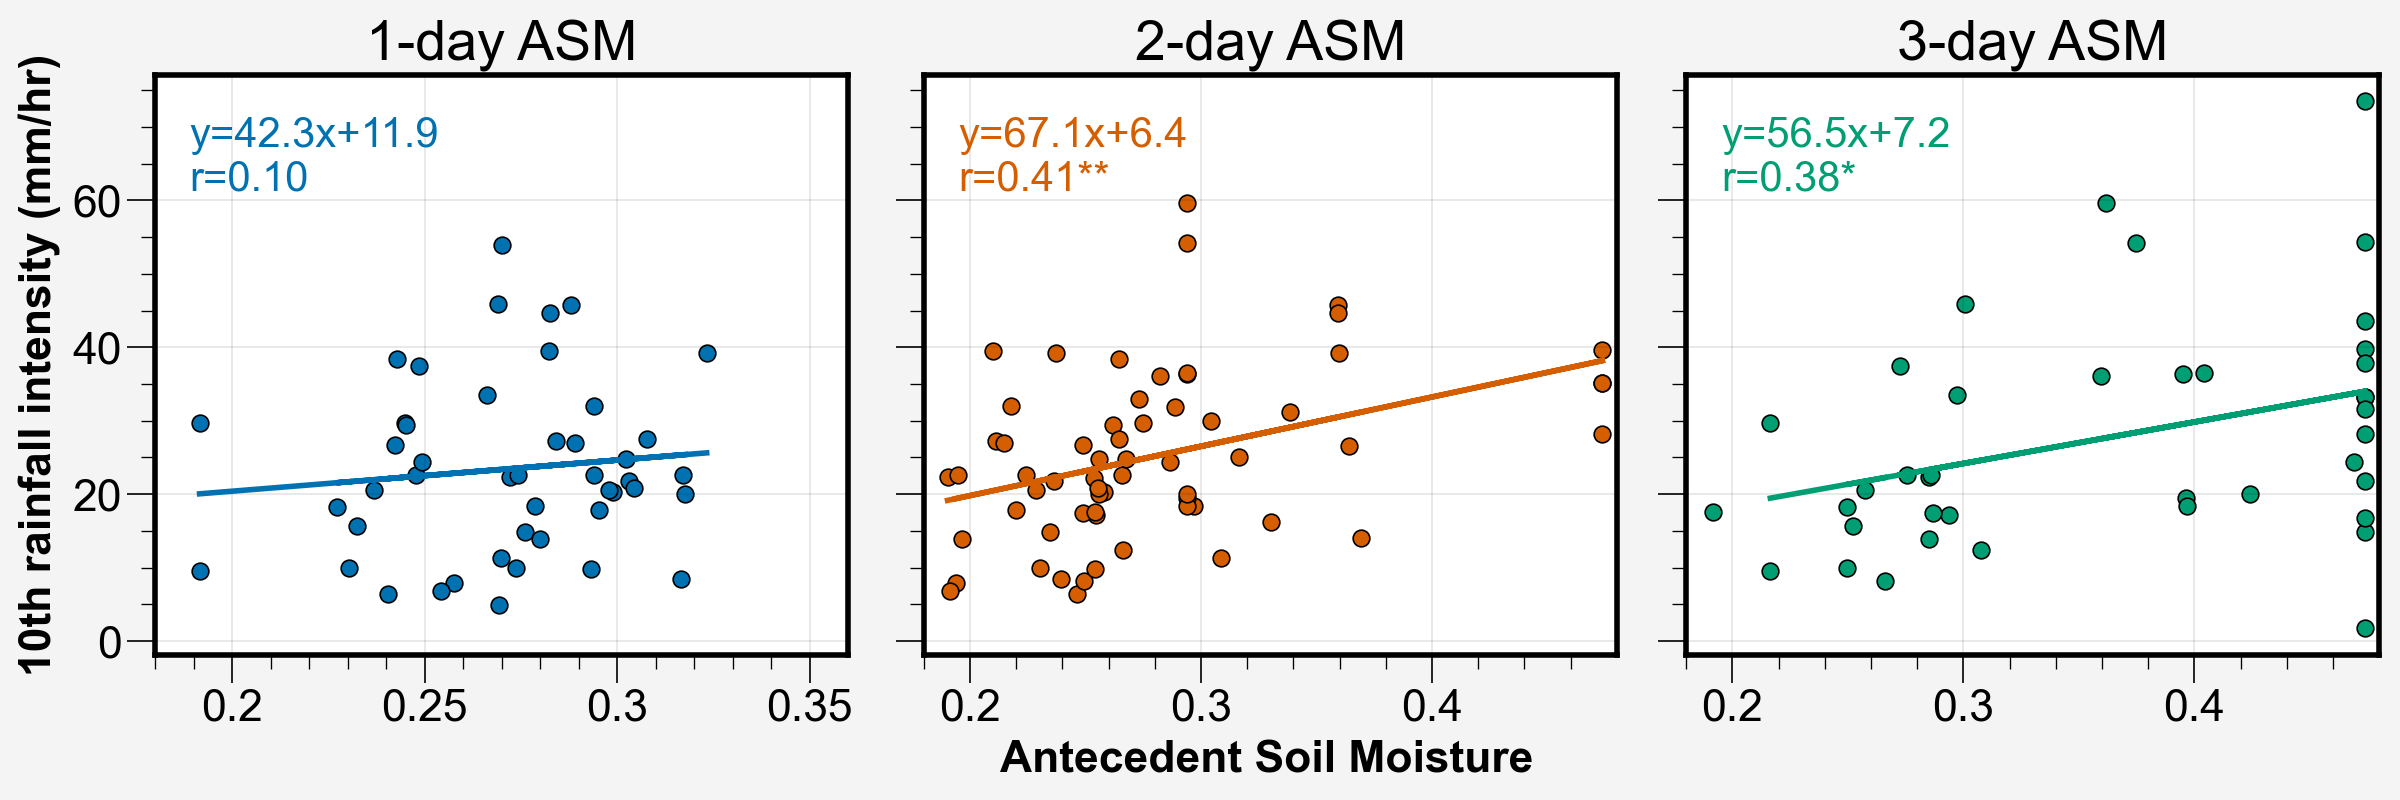

In [546]:
intensity= 'INTENSITY_99'
fig= pplt.figure(figsize=(12,4))
ax= fig.add_subplot(131)
ax.scatter(info_2d.ASM_1day, info_2d[intensity], label='1-day ASM', color='C0', ec='k')
# ax.scatter(info_2d.ASM_2day, info_2d.INTENSITY_99, label='2-day ASM', color='C1')
s,z= np.polyfit(info_2d[~pd.isna(info_2d.ASM_1day)].ASM_1day, info_2d[~pd.isna(info_2d.ASM_1day)][intensity], deg=1)
r,p= spearmanr(info_2d[~pd.isna(info_2d.ASM_1day)].ASM_1day, info_2d[~pd.isna(info_2d.ASM_1day)][intensity])
print(r,p)
ax.plot(info_2d.ASM_1day, info_2d.ASM_1day*s+z, color='C0')
ax.set_title('1-day ASM')
ax.text(0.05, 0.8, 'y=%.1fx+%.1f\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C0')
ax.set_xlim([0.18,0.36])
# ax.set_ylabel('')
# ax.invert_xaxis()
ax= fig.add_subplot(132)
ax.scatter(info_2d.ASM_2day, info_2d[intensity], label='2-day ASM', color='C1', ec='k')
s,z= np.polyfit(info_2d[~pd.isna(info_2d.ASM_2day)].ASM_2day, info_2d[~pd.isna(info_2d.ASM_2day)][intensity], deg=1)
ax.plot(info_2d.ASM_2day, info_2d.ASM_2day*s+z, color='C1')
ax.set_title('2-day ASM')
r,p= spearmanr(info_2d[~pd.isna(info_2d.ASM_2day)].ASM_2day, info_2d[~pd.isna(info_2d.ASM_2day)][intensity])
print(r,p)
ax.set_xlim([0.18,0.48])
ax.text(0.05, 0.8, 'y=%.1fx+%.1f\nr=%.2f**'%(s,z,r), transform=ax.transAxes, color='C1')
# ax.set_xlabel('Antecedent Soil Moisture')
# ax.invert_xaxis()
ax= fig.add_subplot(133)
ax.scatter(info_2d.ASM_3day, info_2d[intensity], label='3-day ASM', color='C2', ec='k')
s,z= np.polyfit(info_2d[~pd.isna(info_2d.ASM_3day)].ASM_3day, info_2d[~pd.isna(info_2d.ASM_3day)][intensity], deg=1)
ax.plot(info_2d.ASM_3day, info_2d.ASM_3day*s+z, color='C2')
r,p= spearmanr(info_2d[~pd.isna(info_2d.ASM_3day)].ASM_3day, info_2d[~pd.isna(info_2d.ASM_3day)][intensity])
print(r,p)
ax.invert_xaxis()
ax.set_xlim([0.18,0.48])
ax.set_title('3-day ASM')
ax.text(0.05, 0.8, 'y=%.1fx+%.1f\nr=%.2f*'%(s,z,r), transform=ax.transAxes, color='C2')
fig.format(ylabel='10th rainfall intensity (mm/hr)', xlabel='Antecedent Soil Moisture');

In [549]:
info_2d['speed']= np.nan

In [552]:
info_3d.columns

Index(['VERSION', 'MODEL', 'DESC', 'FCST_LEAD', 'FCST_VALID', 'OBS_LEAD',
       'OBS_VALID', 'T_DELTA', 'FCST_T_BEG', 'FCST_T_END', 'FCST_RAD',
       'FCST_THR', 'OBS_T_BEG', 'OBS_T_END', 'OBS_RAD', 'OBS_THR', 'FCST_VAR',
       'FCST_UNITS', 'FCST_LEV', 'OBS_VAR', 'OBS_UNITS', 'OBS_LEV',
       'OBJECT_ID', 'OBJECT_CAT', 'CENTROID_X', 'CENTROID_Y', 'CENTROID_T',
       'CENTROID_LAT', 'CENTROID_LON', 'X_DOT', 'Y_DOT', 'AXIS_ANG', 'VOLUME',
       'START_TIME', 'END_TIME', 'CDIST_TRAVELLED', 'INTENSITY_10',
       'INTENSITY_25', 'INTENSITY_50', 'INTENSITY_75', 'INTENSITY_90',
       'INTENSITY_99'],
      dtype='object')

In [559]:
for obj in info_2d.OBJECT_ID.unique():
    _obj= int(obj[-3:])
    _df = info_2d[info_2d.OBJECT_ID==obj]
    for it in range(len(_df)-1):
        val_time= _df.iloc[it].FCST_VALID
        speed= ((_df.iloc[it+1].CENTROID_LON - _df.iloc[it].CENTROID_LON)**2 +
                (_df.iloc[it+1].CENTROID_LAT - _df.iloc[it].CENTROID_LAT)**2)**.5 *100
        info_2d.loc[(info_2d.FCST_VALID==val_time) & (info_2d.OBJECT_ID==obj), 'speed']= speed

0.19454425856181626 0.2353142962198356
-0.04907642882895162 0.7323559509933493
0.0346574696441386 0.8531582521492148


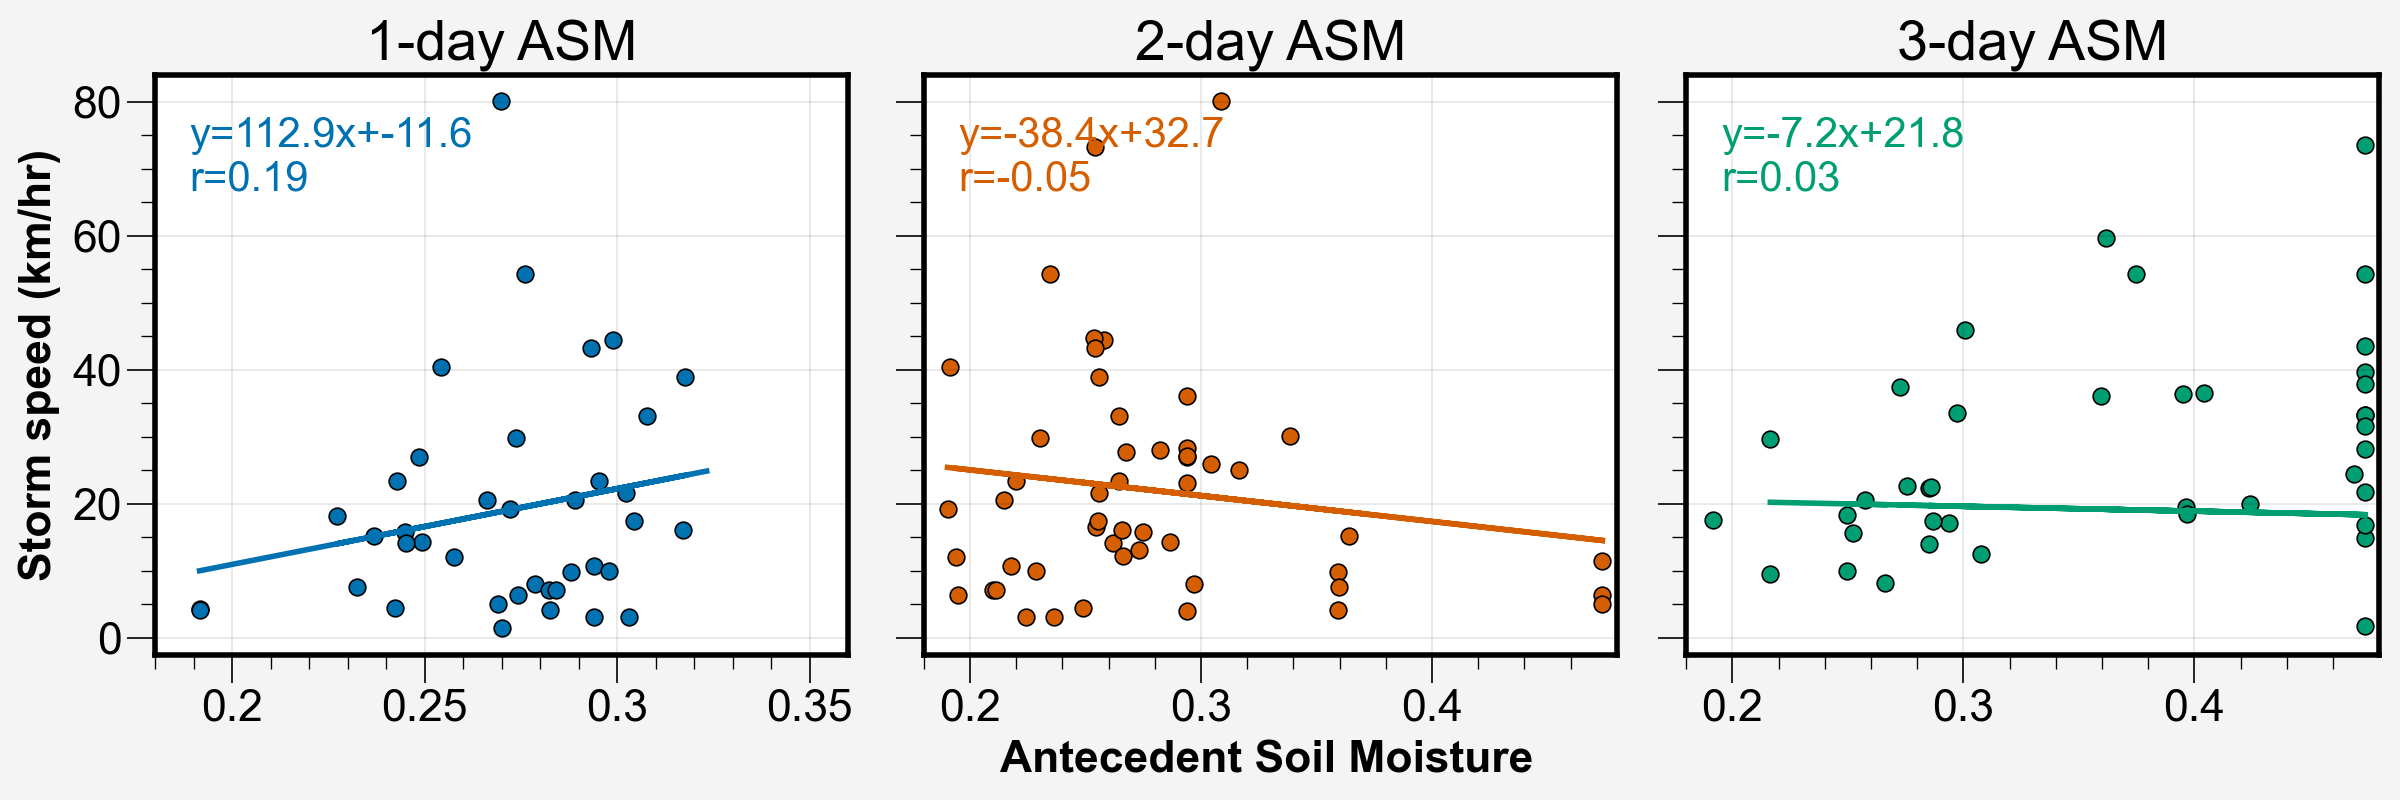

In [562]:
var= 'speed'
fig= pplt.figure(figsize=(12,4))
ax= fig.add_subplot(131)
ax.scatter(info_2d.ASM_1day, info_2d[var], label='1-day ASM', color='C0', ec='k')
# ax.scatter(info_2d.ASM_2day, info_2d.INTENSITY_99, label='2-day ASM', color='C1')
s,z= np.polyfit(info_2d[(~pd.isna(info_2d.ASM_1day)) & (~pd.isna(info_2d[var]))].ASM_1day,
                info_2d[(~pd.isna(info_2d.ASM_1day)) & (~pd.isna(info_2d[var]))][var], deg=1)
r,p= spearmanr(info_2d[(~pd.isna(info_2d.ASM_1day)) & (~pd.isna(info_2d[var]))].ASM_1day,
               info_2d[(~pd.isna(info_2d.ASM_1day)) & (~pd.isna(info_2d[var]))][var])
print(r,p)
ax.plot(info_2d.ASM_1day, info_2d.ASM_1day*s+z, color='C0')
ax.set_title('1-day ASM')
ax.text(0.05, 0.8, 'y=%.1fx+%.1f\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C0')
ax.set_xlim([0.18,0.36])
# ax.set_ylabel('')
# ax.invert_xaxis()
ax= fig.add_subplot(132)
ax.scatter(info_2d.ASM_2day, info_2d[var], label='2-day ASM', color='C1', ec='k')
s,z= np.polyfit(info_2d[(~pd.isna(info_2d.ASM_2day)) & (~pd.isna(info_2d[var]))].ASM_2day,
                info_2d[(~pd.isna(info_2d.ASM_2day)) & (~pd.isna(info_2d[var]))][var], deg=1)
ax.plot(info_2d.ASM_2day, info_2d.ASM_2day*s+z, color='C1')
ax.set_title('2-day ASM')
r,p= spearmanr(info_2d[(~pd.isna(info_2d.ASM_2day)) & (~pd.isna(info_2d[var]))].ASM_2day,
               info_2d[(~pd.isna(info_2d.ASM_2day)) & (~pd.isna(info_2d[var]))][var])
print(r,p)
ax.set_xlim([0.18,0.48])
ax.text(0.05, 0.8, 'y=%.1fx+%.1f\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C1')
# ax.set_xlabel('Antecedent Soil Moisture')
# ax.invert_xaxis()
ax= fig.add_subplot(133)
ax.scatter(info_2d.ASM_3day, info_2d[intensity], label='3-day ASM', color='C2', ec='k')
s,z= np.polyfit(info_2d[(~pd.isna(info_2d.ASM_3day)) & (~pd.isna(info_2d[var]))].ASM_3day,
                info_2d[(~pd.isna(info_2d.ASM_3day)) & (~pd.isna(info_2d[var]))][var], deg=1)
ax.plot(info_2d.ASM_3day, info_2d.ASM_3day*s+z, color='C2')
r,p= spearmanr(info_2d[(~pd.isna(info_2d.ASM_3day)) & (~pd.isna(info_2d[var]))].ASM_3day,
               info_2d[(~pd.isna(info_2d.ASM_3day)) & (~pd.isna(info_2d[var]))][var])
print(r,p)
ax.invert_xaxis()
ax.set_xlim([0.18,0.48])
ax.set_title('3-day ASM')
ax.text(0.05, 0.8, 'y=%.1fx+%.1f\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C2')
fig.format(ylabel='Storm speed (km/hr)', xlabel='Antecedent Soil Moisture');

0.34615384615384615 0.24662526251007164
-0.2104489164296305 0.4340184998606945
-0.22099784804393194 0.4680972489933377


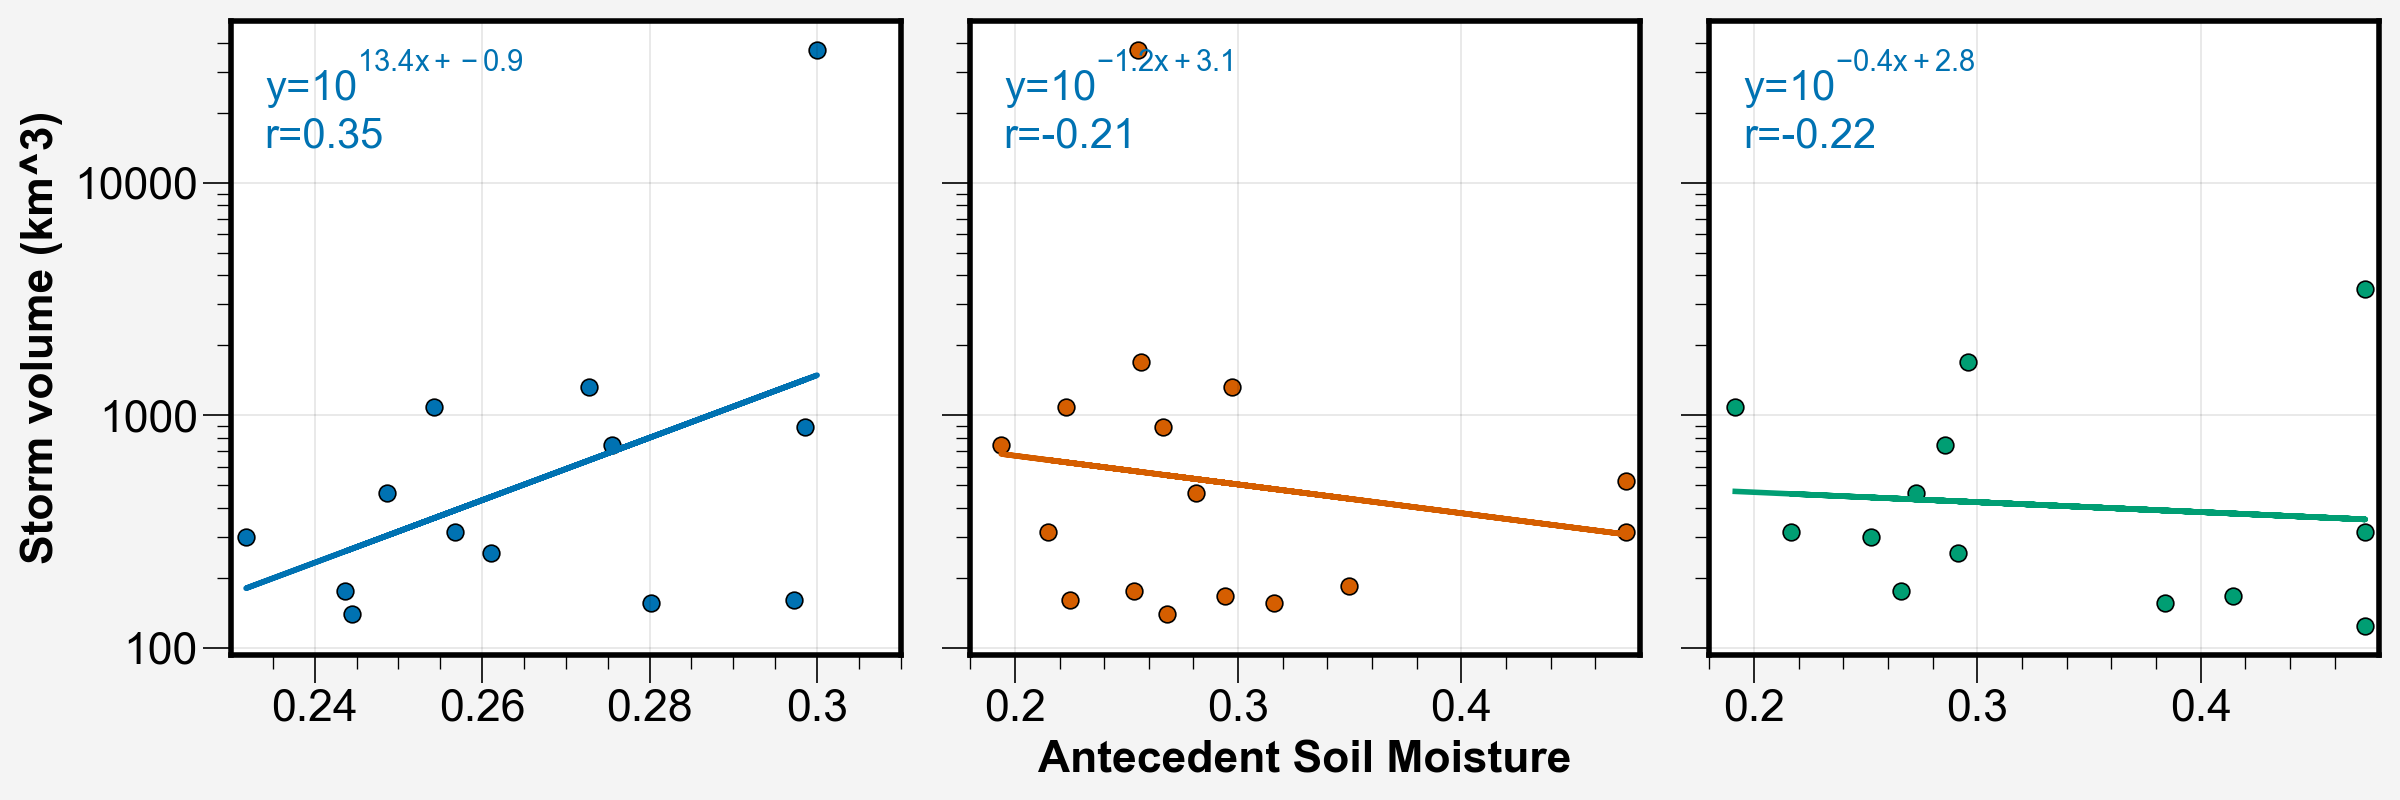

In [583]:
fig= pplt.figure(figsize=(12,4))
ax= fig.add_subplot(131)
x= np.array([np.nanmean(info_2d[info_2d.OBJECT_ID=='F%03d'%_id].ASM_1day) for _id in info_3d.index])
y= info_3d.VOLUME.values
mask= (~np.isnan(x)) & (~np.isnan(y))
x1= x[mask]
y1= np.log10(y[mask])
ax.scatter(x,y, color='C0',ec='k')
s,z= np.polyfit(x1,y1, deg=1)
ax.plot(x1, 10**(x1*s+z), color='C0')
r,p= spearmanr(x1,y1)
print(r,p)
ax.text(0.05, 0.8, 'y=$10^{%.1fx+%.1f}$\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C0')
ax.set_yscale('log')
ax.set_xlim([0.23,0.31])

ax= fig.add_subplot(132)
x= np.array([np.nanmean(info_2d[info_2d.OBJECT_ID=='F%03d'%_id].ASM_2day) for _id in info_3d.index])
y= info_3d.VOLUME.values
mask= (~np.isnan(x)) & (~np.isnan(y))
x1= x[mask]
y1= np.log10(y[mask])
ax.scatter(x,y, color='C1',ec='k')
s,z= np.polyfit(x1,y1, deg=1)
ax.plot(x1, 10**(x1*s+z), color='C1')
r,p= spearmanr(x1,y1)
print(r,p)
ax.text(0.05, 0.8, 'y=$10^{%.1fx+%.1f}$\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C0')
ax.set_yscale('log')
ax.set_xlim([0.18,0.48])

ax= fig.add_subplot(133)
x= np.array([np.nanmean(info_2d[info_2d.OBJECT_ID=='F%03d'%_id].ASM_3day) for _id in info_3d.index])
y= info_3d.VOLUME.values
mask= (~np.isnan(x)) & (~np.isnan(y))
x1= x[mask]
y1= np.log10(y[mask])
ax.scatter(x,y, color='C2',ec='k')
s,z= np.polyfit(x1,y1, deg=1)
ax.plot(x1, 10**(x1*s+z), color='C2')
r,p= spearmanr(x1,y1)
print(r,p)
ax.set_xlim([0.18,0.48])
ax.text(0.05, 0.8, 'y=$10^{%.1fx+%.1f}$\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C0')
ax.set_yscale('log')
fig.format(ylabel='Storm volume (km^3)', xlabel='Antecedent Soil Moisture');

In [588]:
info_3d.CDIST_TRAVELLED

0       27.250
1       79.115
2       16.835
3       84.794
4       14.821
        ...   
61      36.956
62     162.693
63      75.460
64     944.323
65    1545.210
Name: CDIST_TRAVELLED, Length: 66, dtype: float64

0.5274725274725275 0.06395489148355482
-0.3473142956461035 0.18748776319768082
-0.11602387022306428 0.7058335018395139


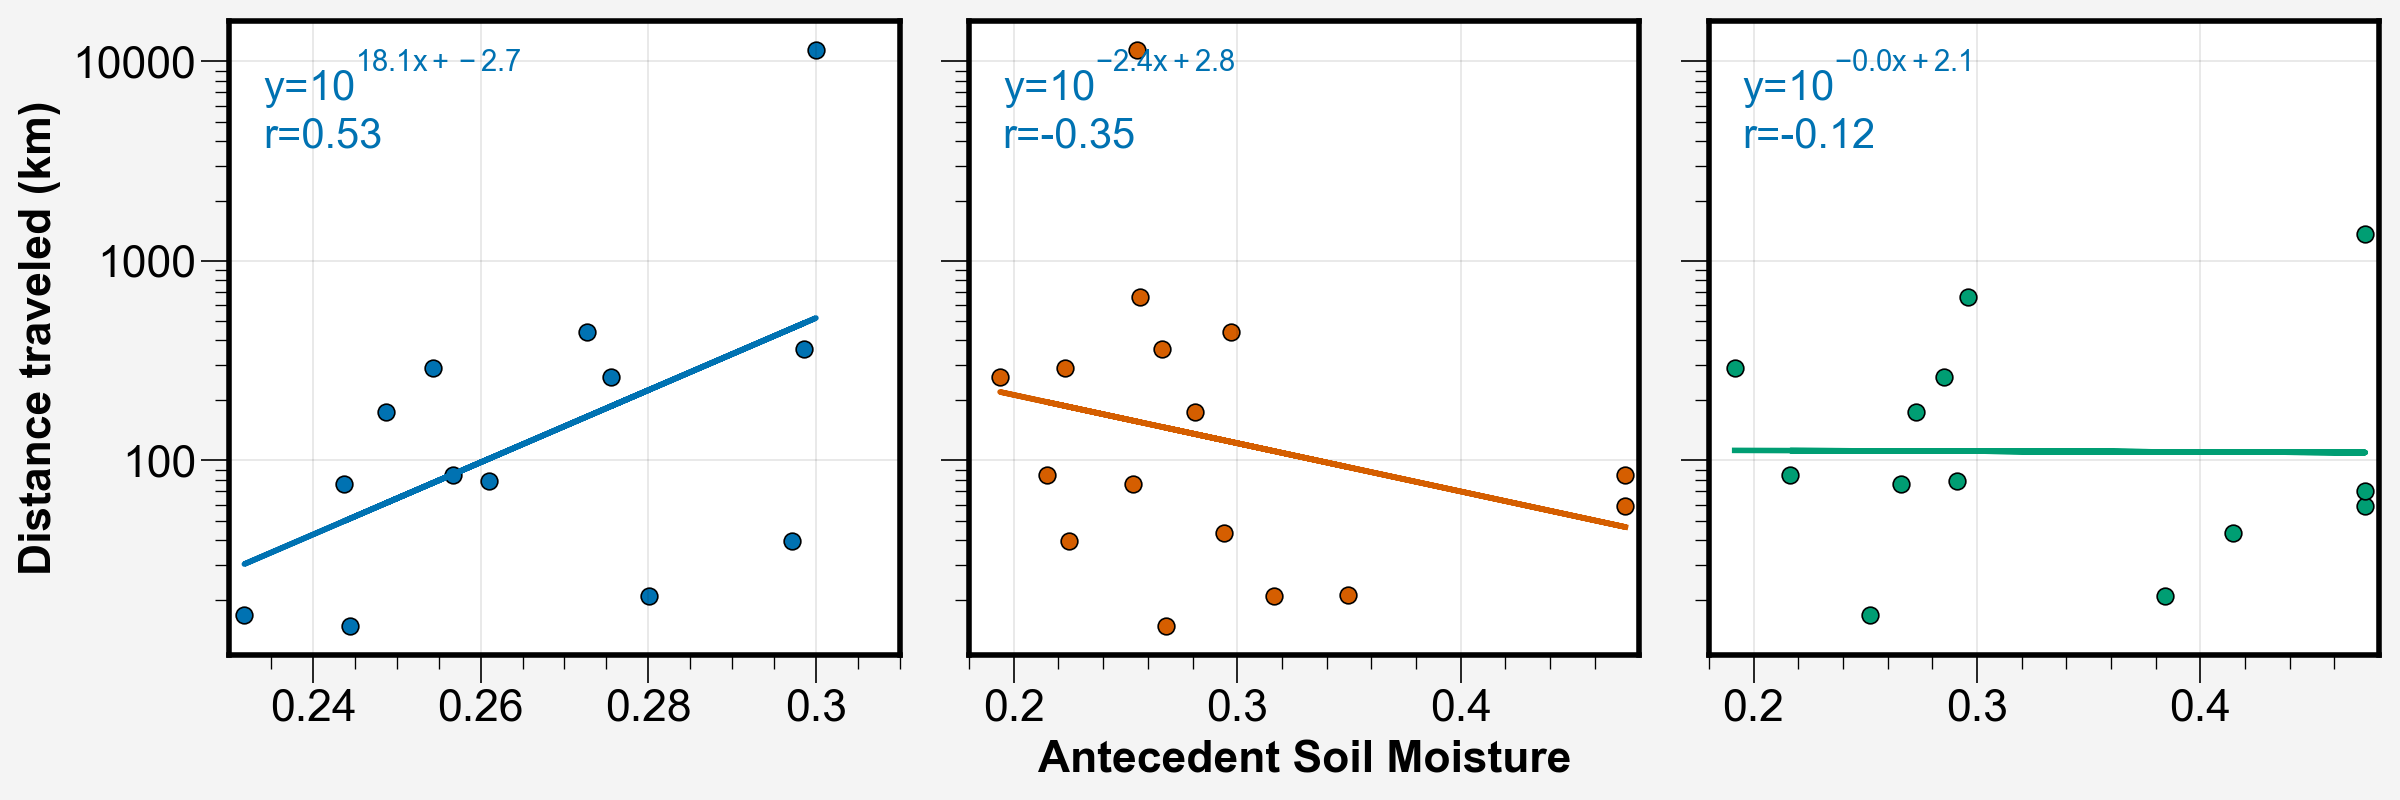

In [598]:
fig= pplt.figure(figsize=(12,4))
ax= fig.add_subplot(131)
x= np.array([np.nanmean(info_2d[info_2d.OBJECT_ID=='F%03d'%_id].ASM_1day) for _id in info_3d.index])
y= info_3d.CDIST_TRAVELLED.values
mask= (~np.isnan(x)) & (~np.isnan(y))
x1= x[mask]
y1= np.log10(y[mask])
ax.scatter(x,y, color='C0',ec='k')
s,z= np.polyfit(x1,y1, deg=1)
ax.plot(x1, 10**(x1*s+z), color='C0')
r,p= spearmanr(x1,y1)
print(r,p)
ax.text(0.05, 0.8, 'y=$10^{%.1fx+%.1f}$\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C0')
ax.set_yscale('log')
ax.set_xlim([0.23,0.31])

ax= fig.add_subplot(132)
x= np.array([np.nanmean(info_2d[info_2d.OBJECT_ID=='F%03d'%_id].ASM_2day) for _id in info_3d.index])
y= info_3d.CDIST_TRAVELLED.values
mask= (~np.isnan(x)) & (~np.isnan(y))
x1= x[mask]
y1= np.log10(y[mask])
ax.scatter(x,y, color='C1',ec='k')
s,z= np.polyfit(x1,y1, deg=1)
ax.plot(x1, 10**(x1*s+z), color='C1')
r,p= spearmanr(x1,y1)
print(r,p)
ax.text(0.05, 0.8, 'y=$10^{%.1fx+%.1f}$\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C0')
ax.set_yscale('log')
ax.set_xlim([0.18,0.48])

ax= fig.add_subplot(133)
x= np.array([np.nanmean(info_2d[info_2d.OBJECT_ID=='F%03d'%_id].ASM_3day) for _id in info_3d.index])
y= info_3d.CDIST_TRAVELLED.values
mask= (~np.isnan(x)) & (~np.isnan(y))
x1= x[mask]
y1= np.log10(y[mask])
ax.scatter(x,y, color='C2',ec='k')
s,z= np.polyfit(x1,y1, deg=1)
ax.plot(x1, 10**(x1*s+z), color='C2')
r,p= spearmanr(x1,y1)
print(r,p)
ax.set_xlim([0.18,0.48])
ax.text(0.05, 0.8, 'y=$10^{%.1fx+%.1f}$\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C0')
ax.set_yscale('log')
fig.format(ylabel='Distance traveled (km)', xlabel='Antecedent Soil Moisture');

In [591]:
info_3d.columns

Index(['VERSION', 'MODEL', 'DESC', 'FCST_LEAD', 'FCST_VALID', 'OBS_LEAD',
       'OBS_VALID', 'T_DELTA', 'FCST_T_BEG', 'FCST_T_END', 'FCST_RAD',
       'FCST_THR', 'OBS_T_BEG', 'OBS_T_END', 'OBS_RAD', 'OBS_THR', 'FCST_VAR',
       'FCST_UNITS', 'FCST_LEV', 'OBS_VAR', 'OBS_UNITS', 'OBS_LEV',
       'OBJECT_ID', 'OBJECT_CAT', 'CENTROID_X', 'CENTROID_Y', 'CENTROID_T',
       'CENTROID_LAT', 'CENTROID_LON', 'X_DOT', 'Y_DOT', 'AXIS_ANG', 'VOLUME',
       'START_TIME', 'END_TIME', 'CDIST_TRAVELLED', 'INTENSITY_10',
       'INTENSITY_25', 'INTENSITY_50', 'INTENSITY_75', 'INTENSITY_90',
       'INTENSITY_99'],
      dtype='object')

In [599]:
y

array([2.7250000e+01, 7.9115000e+01, 1.6835000e+01, 8.4794000e+01,
       1.4821000e+01, 4.3934800e+02, 2.0855000e+01, 7.6532000e+01,
       8.4800000e+01, 5.8806000e+01, 1.7526600e+02, 2.1265000e+01,
       1.1993000e+01, 1.3639000e+03, 3.6336300e+02, 4.3525000e+01,
       2.6295200e+02, 3.9614000e+01, 6.6182100e+02, 7.0186000e+01,
       2.6632900e+02, 1.1459609e+04, 2.8914400e+02, 4.7538100e+03,
       1.4282700e+02, 9.3729000e+01, 3.7940000e+01, 9.4814500e+02,
       3.9506000e+01, 5.1994800e+02, 1.2900400e+02, 1.5646900e+02,
       1.0915200e+02, 4.2415100e+02, 1.5513300e+02, 1.0915550e+03,
       1.2152800e+02, 6.2794000e+01, 2.6425000e+01, 1.5245300e+02,
       5.8985000e+01, 9.4480000e+00, 4.4016000e+01, 2.1102000e+01,
       1.4129000e+01, 1.5569000e+02, 2.5061000e+01, 1.5231700e+02,
       1.6513000e+01, 9.4310000e+01, 4.8316000e+01, 2.6805000e+01,
       7.3780000e+00, 4.3084000e+01, 3.0361202e+04, 6.5172000e+01,
       2.8931300e+02, 2.2536900e+02, 3.6153000e+01, 1.2306600e

In [604]:
x1

array([0.29127646, 0.25226235, 0.38429194, 0.26595697, 0.2164278 ,
       0.47374156, 0.27256645, 0.47374156, 0.41467666, 0.28536865,
       0.29600377, 0.47374156, 0.19156784])

In [603]:
y1

array([  79.115,   16.835,   20.855,   76.532,   84.8  ,   58.806,
        175.266, 1363.9  ,   43.525,  262.952,  661.821,   70.186,
        289.144])

In [606]:
z

-66.18670637319202

In [613]:
p

nan

In [616]:
info_3d.END_TIME

0       2
1       3
2       2
3       3
4       2
     ... 
61    207
62    221
63    220
64    237
65    240
Name: END_TIME, Length: 66, dtype: int64

In [626]:
pd.to_datetime(info_3d.START_TIME)

0    1970-01-01 00:00:00.000000000
1    1970-01-01 00:00:00.000000000
2    1970-01-01 00:00:00.000000000
3    1970-01-01 00:00:00.000000000
4    1970-01-01 00:00:00.000000000
                  ...             
61   1970-01-01 00:00:00.000000205
62   1970-01-01 00:00:00.000000215
63   1970-01-01 00:00:00.000000217
64   1970-01-01 00:00:00.000000223
65   1970-01-01 00:00:00.000000229
Name: START_TIME, Length: 66, dtype: datetime64[ns]

In [615]:
(pd.to_datetime(info_3d.END_TIME) - pd.to_datetime(info_3d.START_TIME))

0     0
1     0
2     0
3     0
4     0
     ..
61    0
62    0
63    0
64    0
65    0
Length: 66, dtype: int64

0.5509662779839086 0.05099668352272628
-0.605301914580265 0.012970071862482798
0.06639061303092923 0.8293844316658071


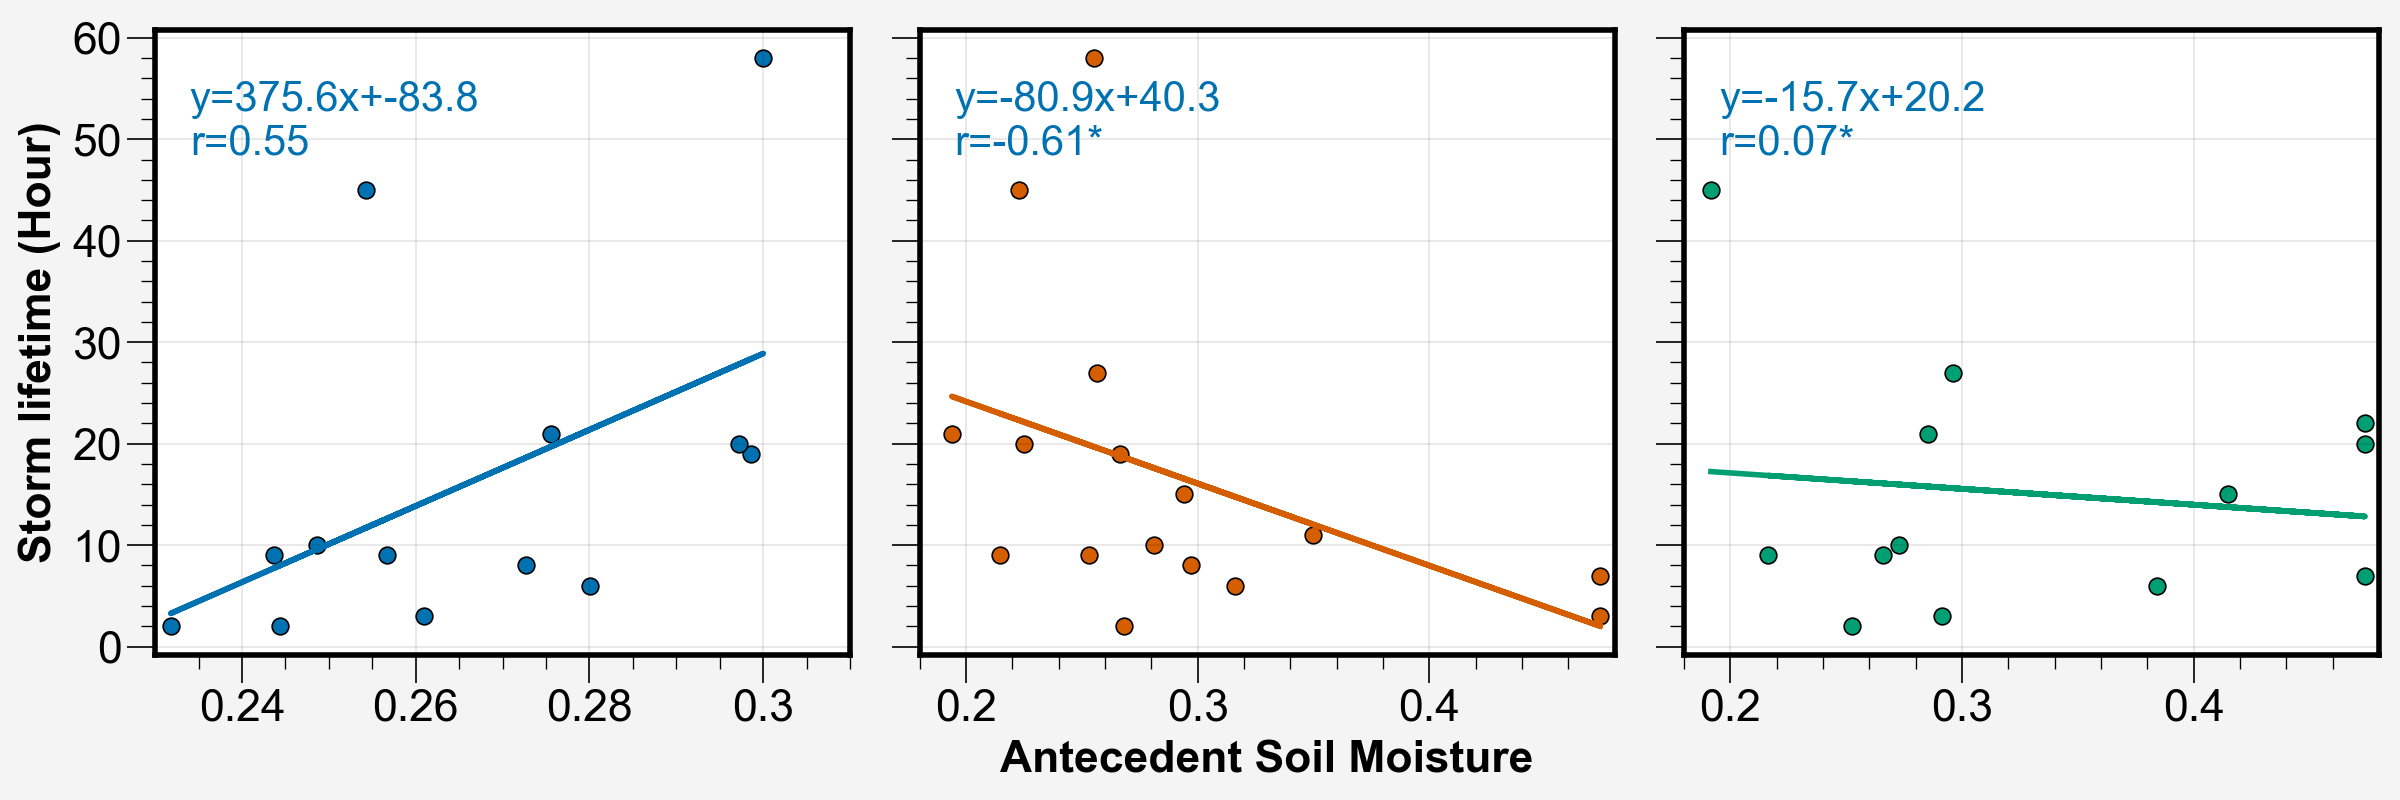

In [633]:
fig= pplt.figure(figsize=(12,4))
ax= fig.add_subplot(131)
x= np.array([np.nanmean(info_2d[info_2d.OBJECT_ID=='F%03d'%_id].ASM_1day) for _id in info_3d.index])
y= info_3d.END_TIME.values
mask= (~np.isnan(x)) & (~np.isnan(y))
x1= x[mask]
y1= y[mask]

ax.scatter(x,y, color='C0',ec='k')
s,z= np.polyfit(x1,y1, deg=1)
ax.plot(x1, x1*s+z, color='C0')
r,p= spearmanr(x1,y1)
print(r,p)
ax.text(0.05, 0.8, 'y=%.1fx+%.1f\nr=%.2f'%(s,z,r), transform=ax.transAxes, color='C0')
# ax.set_yscale('log')
ax.set_xlim([0.23,0.31])

ax= fig.add_subplot(132)
x= np.array([np.nanmean(info_2d[info_2d.OBJECT_ID=='F%03d'%_id].ASM_2day) for _id in info_3d.index])
y= info_3d.END_TIME.values
mask= (~np.isnan(x)) & (~np.isnan(y))
x1= x[mask]
y1= y[mask]
ax.scatter(x,y, color='C1',ec='k')
s,z= np.polyfit(x1,y1, deg=1)
ax.plot(x1, x1*s+z, color='C1')
r,p= spearmanr(x1,y1)
print(r,p)
ax.text(0.05, 0.8, 'y=%.1fx+%.1f\nr=%.2f*'%(s,z,r), transform=ax.transAxes, color='C0')
# ax.set_yscale('log')
ax.set_xlim([0.18,0.48])

ax= fig.add_subplot(133)
x= np.array([np.nanmean(info_2d[info_2d.OBJECT_ID=='F%03d'%_id].ASM_3day) for _id in info_3d.index])
y= info_3d.END_TIME.values
mask= (~np.isnan(x)) & (~np.isnan(y))
x1= x[mask]
y1= y[mask]
ax.scatter(x,y, color='C2',ec='k')
s,z= np.polyfit(x1,y1, deg=1)
ax.plot(x1, x1*s+z, color='C2')
r,p= spearmanr(x1,y1)
print(r,p)
ax.set_xlim([0.18,0.48])
ax.text(0.05, 0.8, 'y=%.1fx+%.1f\nr=%.2f*'%(s,z,r), transform=ax.transAxes, color='C0')
# ax.set_yscale('log')
fig.format(ylabel='Storm lifetime (Hour)', xlabel='Antecedent Soil Moisture');